<a href="https://colab.research.google.com/github/illinois/metapy/blob/master/tutorials/sigir18-topic-models/sigir18-topic-models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
%pip install https://github.com/illinois/metapy/releases/download/v0.2.14/metapy-0.2.14-cp37-cp37m-manylinux_2_24_x86_64.whl

# Exercise 2: Topic Model Inference in LDA

First, let's import the Python bindings for MeTA:

In [2]:
import metapy

If you don't have `metapy` installed, you can install it with a

```bash
pip install metapy
```

on the command line on Linux, macOS, or Windows for either Python 2.7 or Python 3.x. (I will be using Python 3.6 in this tutorial.)

Double-check that you are running the latest version. Right now, that should be `0.2.10`.

In [3]:
metapy.__version__

'0.2.14'

Now, let's set MeTA to log to standard error so we can see progress output for long-running commands. (Only do this once, or you'll get double the output.)

In [4]:
metapy.log_to_stderr()

Now, let's download all of the files we need for the tutorial.

In [5]:
import urllib.request
import os
import tarfile

if not os.path.exists('sigir18-tutorial.tar.gz'):
    urllib.request.urlretrieve('https://meta-toolkit.org/data/2018-06-25/sigir18-tutorial.tar.gz',
                               'sigir18-tutorial.tar.gz')
    
if not os.path.exists('data'):
    with tarfile.open('sigir18-tutorial.tar.gz', 'r:gz') as files:
        files.extractall()

The tutorial files come with a dataset consisting of four years of NIPS proceedings (full text): 2002, 2007, 2012, and 2017.

To start, we first want to understand what topics are being discussed in NIPS in these for years. To do that, we'll first index the dataset in the `ForwardIndex` format (we want to map documents to the terms that they contain).

In [6]:
fidx = metapy.index.make_forward_index('nips.toml')

1669442344: [info]     Creating forward index: nips-idx/fwd (/metapy/deps/meta/src/index/forward_index.cpp:239)
 > Tokenizing Docs: [======================================> ]  96% ETA 00:00:00 
1669442367: [warning]  Empty document (id = 1435) generated! (/metapy/deps/meta/src/index/forward_index.cpp:335)
 > Tokenizing Docs: [========================================] 100% ETA 00:00:00 
 > Merging: [================================================] 100% ETA 00:00:00 
1669442369: [info]     Done creating index: nips-idx/fwd (/metapy/deps/meta/src/index/forward_index.cpp:278)


Now, let's load in all of the documents into memory so we can start to infer a topic model. I'm going to load them in as a `MulticlassDataset` because each document here has been associated with a label (the year it came from), but you could also load them in as just a standard `Dataset` with no associated labels if you don't plan to use them.

In [7]:
dset = metapy.classify.MulticlassDataset(fidx)

 > Loading instances into memory: [==========================] 100% ETA 00:00:00 


With the documents loaded into memory, we can start to run LDA inference on them to infer the topics and their coverage in each of the documents. There are several choices for inference algorithm in MeTA, so in general you can just pick your favorite. Here, I'm going to pick a parallelized version of Gibbs sampling.

The below will run the sampler for either 1000 iterations or until the log likelihood ($\log P(W \mid Z)$) stabilizes, whichever comes first. (If you want to disable the convergence checking and just run the sampler for a fixed number of iterations, you can add the parameter `convergence=0`.)

In [8]:
model = metapy.topics.LDAParallelGibbs(docs=dset, num_topics=10, alpha=0.1, beta=0.1)
model.run(num_iters=1000)
model.save('lda-pgibbs-nips')

Initialization log likelihood (log P(W|Z)): -2.95517e+07                        
Iteration 1 log likelihood (log P(W|Z)): -2.96563e+07                           
Iteration 2 log likelihood (log P(W|Z)): -2.96286e+07                           
Iteration 3 log likelihood (log P(W|Z)): -2.95768e+07                           
Iteration 4 log likelihood (log P(W|Z)): -2.95138e+07                           
Iteration 5 log likelihood (log P(W|Z)): -2.94556e+07                           
Iteration 6 log likelihood (log P(W|Z)): -2.94013e+07                           
Iteration 7 log likelihood (log P(W|Z)): -2.93548e+07                           
Iteration 8 log likelihood (log P(W|Z)): -2.93186e+07                           
Iteration 9 log likelihood (log P(W|Z)): -2.92864e+07                           
Iteration 10 log likelihood (log P(W|Z)): -2.92605e+07                          
Iteration 11 log likelihood (log P(W|Z)): -2.92352e+07                          
Iteration 12 log likelihood 

Once the above converges, it will save the results to disk. We can load the results into memory for inspection by loading an instance of the `TopicModel` class:

In [9]:
model = metapy.topics.TopicModel('lda-pgibbs-nips')

 > Loading topic term probabilities: [=======================] 100% ETA 00:00:00 
 > Loading document topic probabilities: [===================] 100% ETA 00:00:00 


What do the topics discussed in NIPS over the last two decades roughly look like?

In [10]:
for topic in range(0, model.num_topics()):
    print("Topic {}:".format(topic + 1))
    for tid, val in model.top_k(topic, 10, metapy.topics.BLTermScorer(model)):
        print("{}: {}".format(fidx.term_text(tid), val))
    print("======\n")

Topic 1:
model: 0.055392547936968774
topic: 0.042595314241350817
latent: 0.03464655578342258
item: 0.033345520995375647
word: 0.029534830106355697
document: 0.027077139208697257
cluster: 0.02440168603679127
user: 0.022251867647002137
infer: 0.021912218760069546
languag: 0.0202801508315738

Topic 2:
matrix: 0.06632772661350783
norm: 0.027907611761353132
rank: 0.023647797854344788
kernel: 0.023616973385520986
spars: 0.02216303934165964
eigenvalu: 0.019339865001195666
convex: 0.015341208415887611
theorem: 0.015305011578433139
matric: 0.015182752528606973
subspac: 0.013097876290030008

Topic 3:
convex: 0.06507547081124679
bound: 0.05870777977057262
regret: 0.04647665756762068
xt: 0.04224224423453339
algorithm: 0.03858231976944789
converg: 0.033517415307357905
theorem: 0.030572843413633383
gradient: 0.028066767893575678
loss: 0.024002464533520354
optim: 0.023864164786751737

Topic 4:
neuron: 0.09838141599839396
spike: 0.08231184375798756
stimulus: 0.033556209982588125
cell: 0.03150202268942

# Exercise 3: Text Mining using Topic Models

## Topics over Time

An interesting "mining" question to ask on top of this is whether or not the topics used in NIPS have changed over time. Are certain topics exhibited only in the earlier years, or vice-versa?

To do this, let's take a look at the other output of LDA---the topic proportion vectors associated with each document. Since each document also has a label in our dataset, we can create plots for each topic to see the number of documents that mention a specific topic in a specific year, and to what degree.

We'll start by creating a simple dataset with `pandas`:

In [11]:
import pandas as pd

data = []
for doc in dset:
    proportions = model.topic_distribution(doc.id)
    data.append([dset.label(doc)] + [proportions.probability(i) for i in range(0, model.num_topics())])
df = pd.DataFrame(data, columns=['label'] + ["Topic {}".format(i + 1) for i in range(0, model.num_topics())])

Now, let's plot the results. There a lot of ways to do this, but here I'm going to use a "swarm plot" so we can see where each and every document falls.

Topic 1


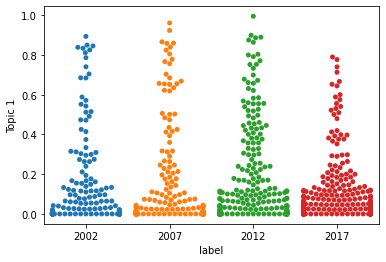

Topic 2


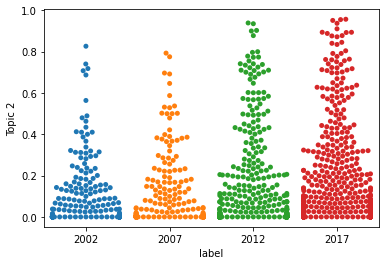

Topic 3


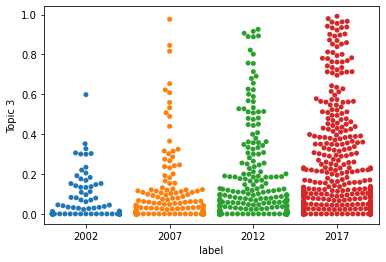

Topic 4


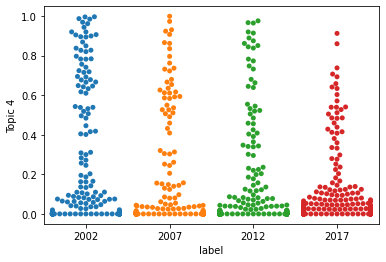

Topic 5


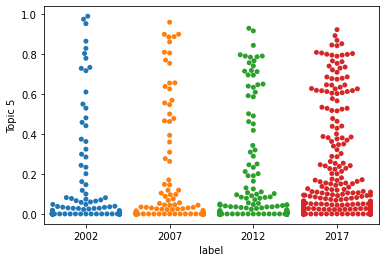

Topic 6


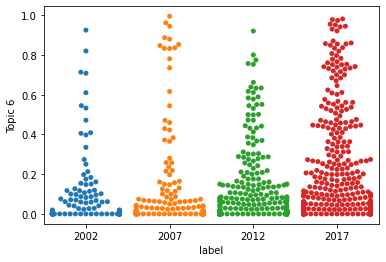

Topic 7


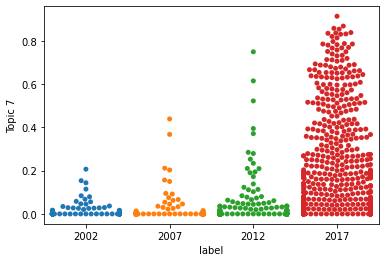

Topic 8


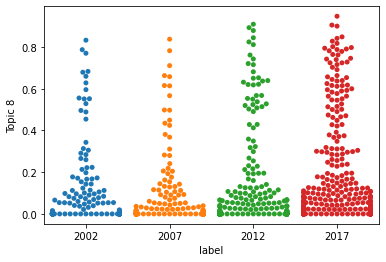

Topic 9


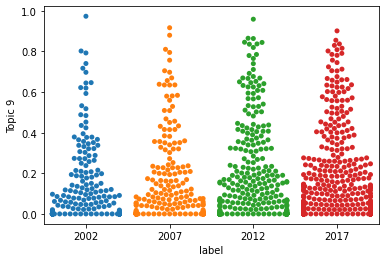

Topic 10


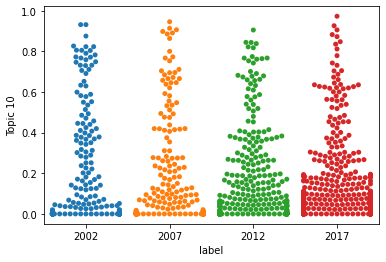

In [12]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# otherwise, seaborn is very noisy
warnings.simplefilter('ignore', category=UserWarning)

for i in range(0, model.num_topics()):
    print("Topic {}".format(i + 1))
    sns.swarmplot(data=df, x='label', y="Topic {}".format(i + 1))
    plt.show()

## Topic Inference (Unseen Document)

Let's try to figure out what topics are mentioned in a previously unseen document.

In [13]:
%%capture
!wget -N https://raw.githubusercontent.com/illinois/metapy/master/tutorials/sigir18-topic-models/6589-scan-order-in-gibbs-sampling-models-in-which-it-matters-and-bounds-on-how-much.txt

In [14]:
doc = metapy.index.Document()
with open('6589-scan-order-in-gibbs-sampling-models-in-which-it-matters-and-bounds-on-how-much.txt') as f:
    doc.content(f.read())
print("{}...".format(doc.content()[0:500]))

Scan Order in Gibbs Sampling: Models in Which it
Matters and Bounds on How Much
Bryan He, Christopher De Sa, Ioannis Mitliagkas, and Christopher Ré
Stanford University
{bryanhe,cdesa,imit,chrismre}@stanford.edu
Abstract
Gibbs sampling is a Markov Chain Monte Carlo sampling technique that iteratively
samples variables from their conditional distributions. There are two common scan
orders for the variables: random scan and systematic scan. Due to the benefits
of locality in hardware, systematic sc...


We first need to transform the unseen document into the same term-id space used by the topic model.

In [15]:
dvec = fidx.tokenize(doc)

...and then we can create an inferencer on top of our topic model output to infer the topic coverage for this new document:

In [16]:
inferencer = metapy.topics.GibbsInferencer('lda-pgibbs-nips.phi.bin', alpha=0.1)
props = inferencer.infer(dvec, max_iters=100, rng_seed=42)
print(props)

<metapy.stats.Multinomial {0: 0.001111, 1: 0.001111, 2: 0.101111, 3: 0.012222, 4: 0.434444, 5: 0.001111, 6: 0.034444, 7: 0.023333, 8: 0.390000, 9: 0.001111}>


 > Loading topic term probabilities: [=======================] 100% ETA 00:00:00 


## Classification with Topic Features

The topic proportion vectors are also often used as input to a classifier. In our case, since we see some differences between the years 2002 and 2017 in terms of topical coverage, let's see if we can learn to separate documents that were written in 2002 from documents that were written in 2017 on the basis of their topic proportions alone.

In [17]:
# First, create a lightweight view for shuffling
shuffled_view = metapy.classify.MulticlassDatasetView(dset)
shuffled_view.shuffle()

# this dataset will use unigram words as features
words_dset = metapy.classify.MulticlassDataset(
    [doc for doc in shuffled_view if dset.label(doc) == "2002" or dset.label(doc) == "2017"],
    dset.total_features(),
    lambda doc: metapy.learn.FeatureVector(doc.weights),
    lambda doc: dset.label(doc)
)

# this dataset will use topic proportions as features
topic_dset = metapy.classify.MulticlassDataset(
    [doc for doc in shuffled_view if dset.label(doc) == "2002" or dset.label(doc) == "2017"],
    model.num_topics(),
    lambda doc: metapy.learn.FeatureVector((i, model.topic_probability(doc.id, i)) for i in range(0, model.num_topics())),
    lambda doc: dset.label(doc)
)

We'll use a 50/50 training/test split setup.

In [18]:
words_train = words_dset[0:int(len(words_dset)/2)]
words_test = words_dset[int(len(words_dset)/2):]

topics_train = topic_dset[0:int(len(topic_dset)/2)]
topics_test = topic_dset[int(len(topic_dset)/2):]

In [19]:
def make_linear_svm(training):
    return metapy.classify.OneVsAll(training, metapy.classify.SGD, loss_id='hinge')

words_sgd = make_linear_svm(words_train)
topics_sgd = make_linear_svm(topics_train)

print("Words:")
mtrx = words_sgd.test(words_test)
print(mtrx)
mtrx.print_stats()

print("======")
print("Topics:")
mtrx = topics_sgd.test(topics_test)
print(mtrx)
mtrx.print_stats()

Words:

           2002     2017     
         ------------------
    2002 | 0.98     0.0202   
    2017 | 0.0174   0.983    


------------------------------------------------------------
Class       F1 Score    Precision   Recall      Class Dist  
------------------------------------------------------------
2002        0.96        0.942       0.98        0.223       
2017        0.988       0.994       0.983       0.777       
------------------------------------------------------------
Total       0.982       0.982       0.982       
------------------------------------------------------------
443 predictions attempted, overall accuracy: 0.982

Topics:

           2002     2017     
         ------------------
    2002 | 0.707    0.293    
    2017 | 0.0843   0.916    


------------------------------------------------------------
Class       F1 Score    Precision   Recall      Class Dist  
------------------------------------------------------------
2002        0.707       0.707   

While we don't beat unigram words, we still do very well for a model that is only using 10 features compared to the tens of thousands used by the words model:

In [20]:
fidx.unique_terms()

66479

We can also try a straight multiclass classification problem: given a document, predect the year from the topic proportions alone.

In [21]:
topic_dset = metapy.classify.MulticlassDataset(
    [doc for doc in shuffled_view],
    model.num_topics(),
    lambda doc: metapy.learn.FeatureVector((i, model.topic_probability(doc.id, i)) for i in range(0, model.num_topics())),
    lambda doc: dset.label(doc)
)

words_train = shuffled_view[0:int(len(shuffled_view)/2)]
words_test = shuffled_view[int(len(shuffled_view)/2):]

topics_train = topic_dset[0:int(len(topic_dset)/2)]
topics_test = topic_dset[int(len(topic_dset)/2):]

In [22]:
words_svm = make_linear_svm(words_train)
topics_svm = make_linear_svm(topics_train)

words_mtrx = words_svm.test(words_test)
topics_mtrx = topics_svm.test(topics_test)

print("Words:")
print(words_mtrx)
words_mtrx.print_stats()

print("========")
print("Topics:")
print(topics_mtrx)
topics_mtrx.print_stats()

Words:

           2002     2007     2012     2017     
         ------------------------------------
    2002 | 0.784    0.124    0.0722   0.0206   
    2007 | 0.373    0.3      0.291    0.0364   
    2012 | 0.137    0.1      0.532    0.232    
    2017 | 0.0059   0.0295   0.0855   0.879    


------------------------------------------------------------
Class       F1 Score    Precision   Recall      Class Dist  
------------------------------------------------------------
2002        0.628       0.524       0.784       0.132       
2007        0.359       0.446       0.3         0.149       
2012        0.563       0.598       0.532       0.258       
2017        0.868       0.856       0.879       0.461       
------------------------------------------------------------
Total       0.687       0.684       0.69        
------------------------------------------------------------
736 predictions attempted, overall accuracy: 0.69

Topics:

           2002     2007     2012     2017    

This is quite a bit harder!